In [1]:
from utils import *
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Vanishing/Exploding Gradient Problem
### Xavier and He initialization

In [2]:
import tensorflow as tf

In [6]:
def leaky_relu(z, name=None):
    return tf.maximum(0.01 * z, z, name=name)

In [5]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name='X')
y = tf.placeholder(tf.int32, shape=(None), name='y')

In [4]:
he_init = tf.variance_scaling_initializer()
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, kernel_initializer=he_init, name='hidden1')

In [7]:
with tf.name_scope('dnn'):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=leaky_relu, name='hidden1')
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=leaky_relu, name='hidden2')
    logits = tf.layers.dense(hidden2, n_outputs, name='outputs')

In [8]:
with tf.name_scope('loss'):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name='loss')

In [9]:
learning_rate = 0.01
with tf.name_scope('train'):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [10]:
with tf.name_scope('eval'):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [11]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [12]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

In [13]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [14]:
n_epochs = 40
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 5 == 0:
            acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
            acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
            print(epoch, "Batch accuracy:", acc_batch, "Validation accuracy:", acc_valid)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Batch accuracy: 0.86 Validation accuracy: 0.9044
5 Batch accuracy: 0.94 Validation accuracy: 0.9494
10 Batch accuracy: 0.92 Validation accuracy: 0.9656
15 Batch accuracy: 0.94 Validation accuracy: 0.971
20 Batch accuracy: 1.0 Validation accuracy: 0.9764
25 Batch accuracy: 1.0 Validation accuracy: 0.978
30 Batch accuracy: 0.98 Validation accuracy: 0.9778
35 Batch accuracy: 1.0 Validation accuracy: 0.9788


## SELU (Sealced Exponential Linear Units)
Activations of **self-normalizing neural networks (SNNs)**
The SELU function is given by 
$$
\mathrm{selu}(x) = \lambda\left\{\begin{array}{ll}x & \mathrm{if}\,\,\mathrm{x} > 0\\
\alpha\mathrm{e}^{x}-\alpha & \mathrm{if}\,\,x\le 0\end{array}\right.
$$

During training, a neural network composed of a stack of dense layers using the SELU activation function will self-normalize: the output of each layer will tend to preserve the same mean and variance during training, which solves the vanishing/exploding gradients problem. As a result, this activation function outperforms the other activation functions very significantly for such neural nets.

In [15]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

In [16]:
def selu(z, scale=1.0507009873554804934193349852946,alpha=1.6732632423543772848170429916717):
    return scale * elu(z, alpha)

Saving figure selu_plot


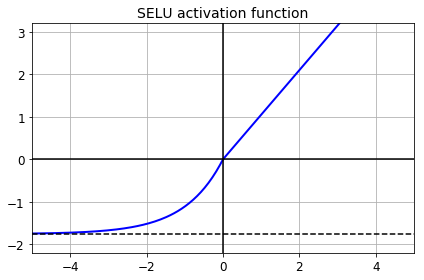

In [18]:
z = np.linspace(-5, 5, 200)

plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("selu_plot")
plt.show()

By default, the SELU hyperparameters (`scale` and `alpha`) are tuned in such a way that the mean remains close to 0 and the standard deviation remains close to 1 (assuming the inputs are standardized with mean 0 and standard deviation 1 too). Using this activation function, even a 100 layer deep neural network preserves roughtly mean 0 and standard deviation 1 across all layers, avoiding the exploding/vanishing gradient problem.

In [19]:
np.random.seed(42)
Z = np.random.normal(size=(500, 100))
for layer in range(100):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(1/100))
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis=1)
    stds = np.std(Z, axis=1)
    if layer % 10 == 0:
        print('Layer {}: {:.2f} < mean < {:.2f}, {:.2f} < std deviation < {:.2f}'.format(
        layer, means.min(), means.max(), stds.min(), stds.max()))

Layer 0: -0.26 < mean < 0.27, 0.74 < std deviation < 1.27
Layer 10: -0.24 < mean < 0.27, 0.74 < std deviation < 1.27
Layer 20: -0.17 < mean < 0.18, 0.74 < std deviation < 1.24
Layer 30: -0.27 < mean < 0.24, 0.78 < std deviation < 1.20
Layer 40: -0.38 < mean < 0.39, 0.74 < std deviation < 1.25
Layer 50: -0.27 < mean < 0.31, 0.73 < std deviation < 1.27
Layer 60: -0.26 < mean < 0.43, 0.74 < std deviation < 1.35
Layer 70: -0.19 < mean < 0.21, 0.75 < std deviation < 1.21
Layer 80: -0.18 < mean < 0.16, 0.72 < std deviation < 1.19
Layer 90: -0.19 < mean < 0.16, 0.75 < std deviation < 1.20


However, the SELU activation function cannot be used along with regular Dropout (this would cancel the SELU activation function's self-normalizing property). Fortunately, there is a Dropout variant called Alpha Dropout proposed in the same paper.

In [20]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name='X')
y = tf.placeholder(tf.int32, shape=(None), name='y')

with tf.name_scope('dnn'):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.selu, name='hidden1')
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.selu, name='hidden2')
    logits = tf.layers.dense(hidden2, n_outputs, name='outputs')
    
with tf.name_scope('loss'):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name='loss')

learning_rate = 0.01

with tf.name_scope('train'):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)
    
with tf.name_scope('eval'):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()
n_epochs = 40
batch_size = 50

In [22]:
means = X_train.mean(axis=0, keepdims=True)
stds = X_train.std(axis=0, keepdims=True) + 1e-10
X_val_scaled = (X_valid - means) / stds

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            X_batch_scaled = (X_batch - means) / stds
            sess.run(training_op, feed_dict={X: X_batch_scaled, y: y_batch})
        if epoch % 5 == 0:
            acc_batch = accuracy.eval(feed_dict={X: X_batch_scaled, y: y_batch})
            acc_valid = accuracy.eval(feed_dict={X: X_val_scaled, y: y_valid})
            print(epoch, 'Batch accuracy:', acc_batch, 'Validation accuracy:', acc_valid)
    save_path = saver.save(sess, './my_model_final_selu.ckpt')

0 Batch accuracy: 0.9 Validation accuracy: 0.9258
5 Batch accuracy: 0.96 Validation accuracy: 0.9556
10 Batch accuracy: 0.96 Validation accuracy: 0.9634
15 Batch accuracy: 1.0 Validation accuracy: 0.967
20 Batch accuracy: 1.0 Validation accuracy: 0.9688
25 Batch accuracy: 1.0 Validation accuracy: 0.969
30 Batch accuracy: 1.0 Validation accuracy: 0.9694
35 Batch accuracy: 1.0 Validation accuracy: 0.9714


## Batch Normalization
Address the vanishing/exploding gradients problems, and more generally the problem that the distribution of each layer's inputs change during training, as the parameters of the previous layers change.

- Adding an operation in the model just before the activation function of each layer, simply zero centering and normalizing the inputs, then scaling and shifting the result using two new parameters per layer (one for scaling, the other for shiftin). In other words, this operation lets the model learning the optimal scale and mean of the inputs for each layer.

- In order to zero center and normalize the inputs, the algorithm needs to estimate the inputs' mean and standard deviation. It does so by evaluating the mean and standard deviation of the inputs over the current mini-batch.

Batch Normalization algorithm
\begin{eqnarray}
\mu_B & = & \frac{1}{m_B}\sum_{i=1}^{m_B}\mathbf{x}^{(i)}\\
\sigma_B^2 & = & \frac{1}{m_B}\sum_{i=1}^{m_B}\left(\mathbf{x}^{(i)}-\mu_B\right)^2 \\
\hat{\mathbf{x}}^{(i)} & = & \frac{\mathbf{x}^{(i)}-\mu_B}{\sqrt{\sigma_B^2 + \epsilon}} \\
\mathbf{z}^{(i)} & = & \gamma\hat{\mathbf{x}}^{(i)} + \beta
\end{eqnarray}
* $\mu_B$ is the empirical mean, evaluated over the whole mini-batch $B$.
* $\sigma_B$ is the empirical standard deviation, also evaluated over the whole mini-batch.
* $m_B$ is the number of instances in the mini-batch.
* $\hat{\mathbf{x}}^{(i)}$ is the zero-centred and normalized input
* $\gamma$ is the scaling parameter for the layer
* $\beta$ is the shifting parameter (offset) for the layer. 
* $\epsilon$ is a tiny number to avoid division by zero (typically 10$^{-3}$. This is called a *smoothing term*.
* $\mathbf{z}^{(i)}$ is the output of the BN operation: it is a scaled and shifted version of the inputs.

In [23]:
reset_graph()

import tensorflow as tf

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

In [38]:
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name='X')

training = tf.placeholder_with_default(False, shape=(), name='training')

hidden1 = tf.layers.dense(X, n_hidden1, name='hidden1')
bn1 = tf.layers.batch_normalization(hidden1, training=training, momentum=0.9)
bn1_act = tf.nn.elu(bn1)

hidden2 = tf.layers.dense(bn1_act, n_hidden2, name='hidden2')
bn2 = tf.layers.batch_normalization(hidden2, training=training, momentum=0.9)
bn2_act = tf.nn.elu(bn2)

logits_before_bn = tf.layers.dense(bn2_act, n_outputs, name='outputs')
logits = tf.layers.batch_normalization(logits_before_bn, training=training, momentum=0.9)

In [39]:
reset_graph()
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name='X')
training = tf.placeholder_with_default(False, shape=(), name='training')

In [40]:
from functools import partial

my_batch_norm_layer = partial(tf.layers.batch_normalization, training=training, momentum=0.9)

hidden1 = tf.layers.dense(X, n_hidden1, name='hidden1')
bn1 = my_batch_norm_layer(hidden1)
bn1_act = tf.nn.elu(bn1)
hidden2 = tf.layers.dense(bn1_act, n_hidden2, name='hidden2')
bn2 = my_batch_norm_layer(hidden2)
bn2_act = tf.nn.elu(bn2)
logits_before_bn = tf.layers.dense(bn2_act, n_outputs, name='outputs')
logits = my_batch_norm_layer(logits_before_bn)

Example:

In [43]:
reset_graph()

batch_norm_momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name='X')
y = tf.placeholder(tf.int32, shape=(None), name='y')
training = tf.placeholder_with_default(False, shape=(), name='training')

with tf.name_scope('dnn'):
    he_init = tf.variance_scaling_initializer()
    
    my_batch_norm_layer = partial(tf.layers.batch_normalization, training=training, momentum=batch_norm_momentum)
    
    my_dense_layer = partial(tf.layers.dense, kernel_initializer=he_init)
    
    hidden1 = my_dense_layer(X, n_hidden1, name='hidden1')
    bn1 = tf.nn.elu(my_batch_norm_layer(hidden1))
    hidden2 = my_dense_layer(bn1, n_hidden2, name='hidden2')
    bn2 = tf.nn.elu(my_batch_norm_layer(hidden2))
    logits_before_bn = my_dense_layer(bn2, n_outputs, name='outputs')
    logits = my_batch_norm_layer(logits_before_bn)
    
with tf.name_scope('loss'):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name='loss')
    
with tf.name_scope('train'):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)
    
with tf.name_scope('eval'):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [44]:
n_epochs = 20
batch_size = 200

In [45]:
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

In [46]:
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run([training_op, extra_update_ops], feed_dict={training:True, X:X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, 'Validation accuracy:', accuracy_val)
        
    save_path = saver.save(sess, './my_model_final.ckpt')

0 Validation accuracy: 0.8952
1 Validation accuracy: 0.9202
2 Validation accuracy: 0.9318
3 Validation accuracy: 0.9422
4 Validation accuracy: 0.9468
5 Validation accuracy: 0.954
6 Validation accuracy: 0.9568
7 Validation accuracy: 0.96
8 Validation accuracy: 0.962
9 Validation accuracy: 0.9638
10 Validation accuracy: 0.9662
11 Validation accuracy: 0.9682
12 Validation accuracy: 0.9672
13 Validation accuracy: 0.9696
14 Validation accuracy: 0.9706
15 Validation accuracy: 0.9704
16 Validation accuracy: 0.9718
17 Validation accuracy: 0.9726
18 Validation accuracy: 0.9738
19 Validation accuracy: 0.9742


What!? That's not a great accuracy for MNIST. Of course, if you train for longer it will get much better accuracy, but with such a shallow network, Batch Norm and ELU are unlikely to have very positive impact: they shine mostly for much deeper nets.

Note that you could also make the training operation depend on the update operations:
```python
with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(extra_update_ops):
        training_op = optimizer.minimize(loss)
```
This way, you would just have to evaluate the training_op during training, TensorFlow would automatically run the update operations as well:
```python
    sess.run(training_op, feed_dict={training: True, X: X_batch, y: y_batch})
```
One more thing: notice that the list of trainable variables is shorter than the list of all global variables. This is because the moving averages are non-trainable variables. If you want to reuse a pretrained neural network (see below), you must not forget these non-trainable variables.

In [47]:
[v.name for v in tf.trainable_variables()]

['hidden1/kernel:0',
 'hidden1/bias:0',
 'batch_normalization/gamma:0',
 'batch_normalization/beta:0',
 'hidden2/kernel:0',
 'hidden2/bias:0',
 'batch_normalization_1/gamma:0',
 'batch_normalization_1/beta:0',
 'outputs/kernel:0',
 'outputs/bias:0',
 'batch_normalization_2/gamma:0',
 'batch_normalization_2/beta:0']

In [48]:
[v.name for v in tf.global_variables()]

['hidden1/kernel:0',
 'hidden1/bias:0',
 'batch_normalization/gamma:0',
 'batch_normalization/beta:0',
 'batch_normalization/moving_mean:0',
 'batch_normalization/moving_variance:0',
 'hidden2/kernel:0',
 'hidden2/bias:0',
 'batch_normalization_1/gamma:0',
 'batch_normalization_1/beta:0',
 'batch_normalization_1/moving_mean:0',
 'batch_normalization_1/moving_variance:0',
 'outputs/kernel:0',
 'outputs/bias:0',
 'batch_normalization_2/gamma:0',
 'batch_normalization_2/beta:0',
 'batch_normalization_2/moving_mean:0',
 'batch_normalization_2/moving_variance:0']

## Gradient Clipping
A popular technique to lessen the exploding gradient problem is to simply clip the gradient during backpropagation so that they never exceed some threshold. Now people generally prefer batch normalization.

Let's create a simple neural net for MNIST and add gradient clipping. The first part is the same as earlier (except we added a few more layers to demonstrate reusing pretrained models)

In [49]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 50
n_hidden3 = 50
n_hidden4 = 50
n_hidden5 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name='X')
y = tf.placeholder(tf.int32, shape=(None), name='y')

with tf.name_scope('dnn'):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name='hidden1')
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name='hidden2')
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name='hidden3')
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name='hidden4')
    hidden5 = tf.layers.dense(hidden4, n_hidden5, activation=tf.nn.relu, name='hidden5')
    logits = tf.layers.dense(hidden5, n_outputs, name='outputs')

with tf.name_scope('loss'):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name='loss')

In [50]:
learning_rate = 0.01

In [51]:
threshold = 1.0

optimizer = tf.train.GradientDescentOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(loss)
capped_gvs = [(tf.clip_by_value(grad, -threshold, threshold), var) for grad, var in grads_and_vars]
training_op = optimizer.apply_gradients(capped_gvs)

In [52]:
with tf.name_scope('eval'):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name='accuracy')

In [53]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [54]:
n_epochs = 20
batch_size= 200

In [55]:
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X:X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X:X_valid, y:y_valid})
        print(epoch, 'Validation accuracy:', accuracy_val)
    save_path = saver.save(sess, './my_model_final.ckpt')

0 Validation accuracy: 0.2878
1 Validation accuracy: 0.7938
2 Validation accuracy: 0.88
3 Validation accuracy: 0.9062
4 Validation accuracy: 0.9162
5 Validation accuracy: 0.922
6 Validation accuracy: 0.9294
7 Validation accuracy: 0.9356
8 Validation accuracy: 0.938
9 Validation accuracy: 0.9418
10 Validation accuracy: 0.9458
11 Validation accuracy: 0.9472
12 Validation accuracy: 0.9476
13 Validation accuracy: 0.9532
14 Validation accuracy: 0.9566
15 Validation accuracy: 0.9564
16 Validation accuracy: 0.9576
17 Validation accuracy: 0.959
18 Validation accuracy: 0.9626
19 Validation accuracy: 0.9614


## Reusing Pretrained Layers
It's not generally a good idea to train a very large DNN from scratch. In general should always look for one that you are trying to tackle, then just reuse the lower layers of this network. This is called *transfer learning*.

In [56]:
reset_graph()

In [57]:
saver = tf.train.import_meta_graph('./my_model_final.ckpt.meta')

In [58]:
for op in tf.get_default_graph().get_operations():
    print(op.name)

X
y
hidden1/kernel/Initializer/random_uniform/shape
hidden1/kernel/Initializer/random_uniform/min
hidden1/kernel/Initializer/random_uniform/max
hidden1/kernel/Initializer/random_uniform/RandomUniform
hidden1/kernel/Initializer/random_uniform/sub
hidden1/kernel/Initializer/random_uniform/mul
hidden1/kernel/Initializer/random_uniform
hidden1/kernel
hidden1/kernel/Assign
hidden1/kernel/read
hidden1/bias/Initializer/zeros
hidden1/bias
hidden1/bias/Assign
hidden1/bias/read
dnn/hidden1/MatMul
dnn/hidden1/BiasAdd
dnn/hidden1/Relu
hidden2/kernel/Initializer/random_uniform/shape
hidden2/kernel/Initializer/random_uniform/min
hidden2/kernel/Initializer/random_uniform/max
hidden2/kernel/Initializer/random_uniform/RandomUniform
hidden2/kernel/Initializer/random_uniform/sub
hidden2/kernel/Initializer/random_uniform/mul
hidden2/kernel/Initializer/random_uniform
hidden2/kernel
hidden2/kernel/Assign
hidden2/kernel/read
hidden2/bias/Initializer/zeros
hidden2/bias
hidden2/bias/Assign
hidden2/bias/read
dn

In [59]:
show_graph(tf.get_default_graph())

In [60]:
X = tf.get_default_graph().get_tensor_by_name('X:0')
y = tf.get_default_graph().get_tensor_by_name('y:0')

accuracy = tf.get_default_graph().get_tensor_by_name('eval/accuracy:0')

training_op = tf.get_default_graph().get_operation_by_name('GradientDescent')

In [61]:
for op in (X, y, accuracy, training_op):
    tf.add_to_collection('my_important_ops', op)

In [62]:
X, y, accuracy, training_op = tf.get_collection('my_important_ops')

In [63]:
with tf.Session() as sess:
    saver.restore(sess, './my_model_final.ckpt')
    
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, 'Validation accuracy:', accuracy_val)
    save_path = saver.save(sess, './my_new_model_final.ckpt')

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy: 0.9632
1 Validation accuracy: 0.9632
2 Validation accuracy: 0.9656
3 Validation accuracy: 0.9652
4 Validation accuracy: 0.9644
5 Validation accuracy: 0.965
6 Validation accuracy: 0.9682
7 Validation accuracy: 0.9684
8 Validation accuracy: 0.9684
9 Validation accuracy: 0.9684
10 Validation accuracy: 0.9702
11 Validation accuracy: 0.9714
12 Validation accuracy: 0.9674
13 Validation accuracy: 0.97
14 Validation accuracy: 0.9708
15 Validation accuracy: 0.972
16 Validation accuracy: 0.9726
17 Validation accuracy: 0.971
18 Validation accuracy: 0.9716
19 Validation accuracy: 0.9712


### Reuse Python code
If you have access to the Python code that built the original graph, you can just reuse the parts you need and drop the rest.

In [64]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300 # reusedd
n_hidden2 = 50 # reused
n_hidden3 = 50 # reused
n_hidden4 = 20 # new
n_outputs = 10 # new

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name='X')
y = tf.placeholder(tf.int32, shape=(None), name='y')

with tf.name_scope('dnn'):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name='hidden1')  # reused
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name='hidden2') # reused
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name='hidden3') # reused
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name='hidden4') # new
    logits = tf.layers.dense(hidden4, n_outputs, name='outputs')
    
with tf.name_scope('loss'):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name='loss')
    
with tf.name_scope('eval'):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name='accuracy')
    
with tf.name_scope('train'):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

However, you must create one `Saver` to restore the pretrained model (giving it the list of variables to restore, or else it will complain that the graphs don't match) and another `Saver` to save the new model, once it's trained:

In [65]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='hidden[123]') # regular expression
restore_saver = tf.train.Saver(reuse_vars) # to restore layers 1-3

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, './my_model_final.ckpt')
    
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, 'Validation accuracy:', accuracy_val)
    save_path = saver.save(sess, './my_new_model_final.ckpt')

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy: 0.9018
1 Validation accuracy: 0.9334
2 Validation accuracy: 0.9432
3 Validation accuracy: 0.947
4 Validation accuracy: 0.9518
5 Validation accuracy: 0.9532
6 Validation accuracy: 0.9558
7 Validation accuracy: 0.959
8 Validation accuracy: 0.9588
9 Validation accuracy: 0.9604
10 Validation accuracy: 0.962
11 Validation accuracy: 0.962
12 Validation accuracy: 0.9636
13 Validation accuracy: 0.9662
14 Validation accuracy: 0.9662
15 Validation accuracy: 0.966
16 Validation accuracy: 0.9672
17 Validation accuracy: 0.9676
18 Validation accuracy: 0.9682
19 Validation accuracy: 0.9676


## Reusing Models from other frameworks
In this example, for each variable we want to reuse, we find its initializer's assignment operation, and we get its second input, which corresponds to the initialization value. When we run the initializer, we replace the initialization values with the ones we want, using a `feed_dict`:

In [66]:
reset_graph()
n_inputs = 2
n_hidden1 = 3

In [67]:
original_w = [[1., 2., 3.], [4., 5., 6.]] # Load the weights from the other framework
original_b = [7., 8., 9.]

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name='X')
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name='hidden1')

# Get a handle on the assignment nodes for the hidden1 variables
graph = tf.get_default_graph()
assign_kernel = graph.get_operation_by_name('hidden1/kernel/Assign')
assign_bias = graph.get_operation_by_name('hidden1/bias/Assign')
init_kernel = assign_kernel.inputs[1]
init_bias = assign_bias.inputs[1]

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init, feed_dict={init_kernel:original_w, init_bias: original_b})
    # [...] Train the model on your new task
    print(hidden1.eval(feed_dict={X: [[10.0, 11.0]]}))

[[ 61.  83. 105.]]
